In [1]:
!pip install ucimlrepo

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [76]:
import time
import uuid

In [6]:
import os          #funciones para interactuar con el sistema operativo
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo #Nos deja acceder a un repositorio de datasets de UCI Machine Learning Repository para descargar datos

import yaml #archivos en formato YAML


import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para preprocesamiento e ing de caracteristicas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, power_transform

# Librerias para la canalizacion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline

# Librerias para la regresion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import metrics

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score

import mlflow
import mlflow.sklearn
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

In [9]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print('\nHEADER\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.head().T)
        print('\n\nDATA DESCRIPTION\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.describe().T)
        print('\n\nDATA INFORMATION\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.info())
        print('\n\nDATA FREQUENCY\n--------------------------------------------------------------------------------------------------------------------------------------------')
        print(data.nunique())

    @staticmethod
    def plot_categorical_distributions(data, columns, target):
        figure, axes = plt.subplots(7,5, figsize = (20,28))
        axes = axes.ravel()

        for col, ax in zip(columns, axes):
            sns.countplot(x = data[col], hue = target, ax = ax, palette = 'bright')
            ax.set(title = f'{col}', xlabel = None)

    @staticmethod
    def plot_correlation_matrix(X_data, y_data):
        data = X_data.join(y_data)
        corr_matrix = data.corr(method = 'pearson', numeric_only = True)
        plt.figure(figsize=(17, 10))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Pearson correlation matrix')
        plt.show()


In [109]:
class StudentPerformanceModel:
    def __init__(self, dataset_id):
        self.dataset_id = dataset_id #declarando atributo
        self.data = None #dataframe de def load_data
        self.X_train, self.X_test, self.y_train, self.y_test = [None, None, None, None] #[None] * 4
        self.pipeline = None #def build_pipeline

    # Configurando cliente MLflow
    #   self.client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
    #   self.experiment_name = "Student_Performance_Models"
        mlflow.set_tracking_uri("http://127.0.0.1:5000")

    # Crear experimento en MLflow
        experiment_description = (
            "Experimento para el analisis y prediccion del rendimiento estudiantil usando varios modelos"
        )

        experiment_tags = {
            "project_name": "student-performance-analysis",
            "team": "Equipo39-MLOps",
            "mlflow.note.content": experiment_description,
        }
        
        #SP_experiment = self.client.create_experiment(name="TEST1", tags=experiment_tags)

        # Nos aseguramos de tener un solo experimento con el nombre "Student_Performance_Models"
        #experiment = mlflow.get_experiment_by_name(self.experiment_name)
        #if experiment is None:  
        #    self.experiment_id = self.client.create_experiment(self.experiment_name, tags=experiment_tags)
        #else:
        #    self.experiment_id = experiment.experiment_id
        
        #mlflow.set_tracking_uri("http://127.0.0.1:5000")
        Student_Performance_experiment = mlflow.set_experiment("TEST7")

        #mlflow.set_tags(experiment_tags)

    def load_data(self):
        fetched_data = fetch_ucirepo(id=self.dataset_id) 
        self.data = pd.concat([fetched_data.data.features, fetched_data.data.targets], axis=1)

        column_names = ['Student Age', 'Sex', 'Graduated High-school Type', 'Scholarship Type', 'Additional Work',
                        'Regular Artistic/Sports Activity', 'Do you have a Partner', 'Total Salary', 'Transportation',
                        'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education', 'Number of Siblings',
                        'Parental Status', 'Mothers Occupation', 'Fathers Occupation', 'Weekly Study Hours',
                        'Reading Frequency (Non-Scientific)', 'Reading Frequency (Scientific)', 'Attendance to Seminars',
                        'Impact on Success', 'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                        'Taking Notes in Classes', 'Listening in Classes', 'Discussion Improves Success', 'Flip-Classroom',
                        'Cumulative GPA Last Semester', 'Expected GPA at Graduation', 'COURSE ID', 'OUTPUT Grade']
        self.data.columns = column_names

        return self

    def preprocess_data(self):
        # Definimos X e y
        self.X = self.data.drop('OUTPUT Grade', axis=1)
        self.y = self.data['OUTPUT Grade']

        # Dividimos en conjuntos de entrenamiento y prueba
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)

        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_test, self.y_test, test_size=0.5, stratify=self.y_test, random_state=1)

        print("Division de datos completada")
        print("")
        print("Conjunto de entrenamiento:", self.X_train.shape, self.y_train.shape)
        print("Conjunto de validacion:", self.X_val.shape, self.y_val.shape)
        print("Conjunto de prueba:", self.X_test.shape, self.y_test.shape)
        return self

    def encode_target(self):
        # Codificando la variable objetivo (OUTPUT Grade)
        self.label_encoder = LabelEncoder()
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_val = self.label_encoder.transform(self.y_val)
        self.y_test = self.label_encoder.transform(self.y_test)
        return self

    def build_pipeline(self):
        # Variables categoricas
        catNOM_pipeline = Pipeline(steps=[('OneHot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])
        catORD_pipeline = Pipeline(steps=[('Ordinal', OrdinalEncoder())])

        catNOM_pipeline_nombres = ['Sex', 'Graduated High-school Type',
                'Scholarship Type', 'Additional Work', 'Regular Artistic/Sports Activity',
                'Do you have a Partner',  'Transportation',
                'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education',
                 'Parental Status', 'Mothers Occupation',
                'Fathers Occupation',  'Attendance to Seminars', 'Impact on Success',
                'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                'Taking Notes in Classes', 'Listening in Classes',
                'Discussion Improves Success', 'Flip-Classroom',
                ]
        catORD_pipeline_nombres = ['Student Age', 'Number of Siblings', 'Total Salary', 'Weekly Study Hours', 'Reading Frequency (Non-Scientific)',
                                   'Reading Frequency (Scientific)', 'Cumulative GPA Last Semester', 'Expected GPA at Graduation','Student Age',
                                   'Number of Siblings']

        # Combinar las transformaciones en un ColumnTransformer
        self.pipeline = ColumnTransformer(transformers=[
            ('OHE', catNOM_pipeline, catNOM_pipeline_nombres),
            ('Ordinal', catORD_pipeline, catORD_pipeline_nombres)
        ])
        return self

    def apply_pipeline(self):
        # Aplicando el pipeline al conjunto de train, val y test
        self.X_train = self.pipeline.fit_transform(self.X_train) #Ajustamos y transformamos solo con el conjunto de entrenamiento
        self.X_val = self.pipeline.transform(self.X_val)
        self.X_test = self.pipeline.transform(self.X_test)
        return self

    def train_model_knn(self, n_neighbors=5):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm = 'ball_tree', metric = 'manhattan', weights = 'distance')
        self.model_name = "KNN"
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_dtree(self, max_depth=None, min_samples_split=2):
        self.model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        self.model_name = "Decision Tree"
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_rf(self, n_estimators=100, max_depth=None):
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        self.model_name = "Random Forest"
        self.model.fit(self.X_train, self.y_train)
        return self

    def evaluate_model(self, evaluation_set="validation"): #artifact_path="model_artifacts"
        # Validando corridas activas
        active_run = mlflow.active_run()
        if active_run is not None and active_run.info.lifecycle_stage == 'active':
            mlflow.end_run()
        # Elegir el conjunto de validacion o prueba
        if evaluation_set == "validation":
            X_temp = self.X_val
            y_temp = self.y_val
        else:
            X_temp = self.X_test
            y_temp = self.y_test

        # Evaluar modelo 
        y_pred = self.model.predict(X_temp)#X_val

        run_name = f"{self.model_name} - {uuid.uuid4()}"
        
        with mlflow.start_run(run_name=run_name):
            accuracy = accuracy_score(y_temp, y_pred)
            cm = confusion_matrix(y_temp, y_pred)
            classification_rep = classification_report(y_temp, y_pred)

            # Registrando metricas
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_params(self.model.get_params())
            mlflow.set_tag("Evaluation Set", evaluation_set)
            signature = infer_signature(X_temp, y_pred)
            mlflow.sklearn.log_model(sk_model=self.model,
                                     input_example=X_temp,
                                     #artifact_path=artifact_path,
                                     artifact_path="model", 
                                     signature=signature
                                     )
        
        print(f'\n\nEvaluation of {evaluation_set} set\n')
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
        plt.show()
        print(classification_rep)
        return self

    def cross_validate_model(self):
        # Validacion cruzada
        scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        print(f"Accuracy con validacion cruzada del conjunto de entrenamiento: {np.mean(scores):.4f}")#calculamos el promedio el accuracy de los 5 folders
        return self

Division de datos completada

Conjunto de entrenamiento: (101, 31) (101,)
Conjunto de validacion: (22, 31) (22,)
Conjunto de prueba: (22, 31) (22,)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


2024/10/18 13:52:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Decision Tree - b590f391-ac28-4dfa-a1e2-bc0087b7c153 at: http://127.0.0.1:5000/#/experiments/303507848156619236/runs/7c11a332907c49a79bea42c44ae4403a.
2024/10/18 13:52:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/303507848156619236.




Evaluation of test set



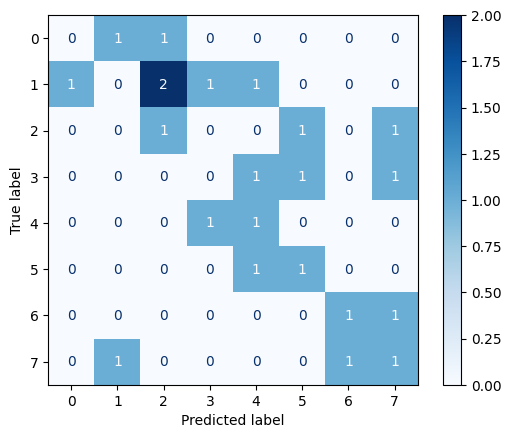

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         5
           2       0.25      0.33      0.29         3
           3       0.00      0.00      0.00         3
           4       0.25      0.50      0.33         2
           5       0.33      0.50      0.40         2
           6       0.50      0.50      0.50         2
           7       0.25      0.33      0.29         3

    accuracy                           0.23        22
   macro avg       0.20      0.27      0.23        22
weighted avg       0.17      0.23      0.19        22

Accuracy con validacion cruzada del conjunto de entrenamiento: 0.1086


In [110]:
model = StudentPerformanceModel(dataset_id=856)
model.load_data()
model.preprocess_data()

# EDA
#DataExplorer.explore_data(model.data) # def explore_data(data):
#DataExplorer.plot_correlation_matrix(model.X_train, model.y_train) # def plot_correlation_matrix(X_data, y_data):
#DataExplorer.plot_categorical_distributions(model.X_train, model.data.columns[:-1], model.y_train) # def plot_categorical_distributions(data, columns, target)

# Modelling and processing
model.encode_target().build_pipeline().apply_pipeline().train_model_dtree().evaluate_model("test").cross_validate_model()

# Pruebas en caso de querer revisar la informacion de los experimentos o perder la conexion

In [88]:
from pprint import pprint

mlflow.set_tracking_uri("http://127.0.0.1:5000")
client = MlflowClient()

# Buscando todos los experimentos que pudieramos tener
all_experiments = client.search_experiments()

# Imprimiendo todos los experimentos
print("\nTodos los experimentos:")
for experiment in all_experiments:
    print(f"ID: {experiment.experiment_id}, Nombre: {experiment.name}, Lifecycle Stage: {experiment.lifecycle_stage}")

# Filtrar por el project_name 
experiments_with_tag = client.search_experiments(
    filter_string="tags.`project_name` = 'student-performance-analysis'"
)

# Imprimiendo la informacion del experimento filtrado
if experiments_with_tag:
    print("\nExperimentos con el tag 'student-performance-analysis':")
    for exp in experiments_with_tag:
        pprint(exp)
else:
    print("\nNo se encontraron experimentos con el tag 'student-performance-analysis'")

#________________________________________________________________________________________________________________________________-
# Filtrando por nombre de experimento
experiment_name_to_search = "TEST7"  # Nombre del experimento

experiment_by_name = [
    experiment for experiment in all_experiments if experiment.name == experiment_name_to_search
]

# Informacion del experimento buscado
if experiment_by_name:
    print(f"\nDetalles del experimento '{experiment_name_to_search}':")
    pprint(experiment_by_name[0])
else:
    print(f"\nNo se encontro ningún experimento con nombre '{experiment_name_to_search}'")


Todos los experimentos:
ID: 303507848156619236, Nombre: TEST7, Lifecycle Stage: active
ID: 783596644566746721, Nombre: Test Connection2, Lifecycle Stage: active
ID: 888609833316324283, Nombre: Apple_Models, Lifecycle Stage: active
ID: 471557891676881090, Nombre: /wine-quality, Lifecycle Stage: active
ID: 638346284818800958, Nombre: MLflow Quickstart, Lifecycle Stage: active
ID: 0, Nombre: Default, Lifecycle Stage: active

No se encontraron experimentos con el tag 'student-performance-analysis'

Detalles del experimento 'TEST7':
<Experiment: artifact_location='mlflow-artifacts:/303507848156619236', creation_time=1729270461093, experiment_id='303507848156619236', last_update_time=1729270461093, lifecycle_stage='active', name='TEST7', tags={}>


In [ ]:
import mlflow
logged_model = 'runs:/873573f266714ab0aefb8d38902ebbfb/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

In [57]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Inicia un experimento de prueba
mlflow.set_experiment("Test Connection2")

with mlflow.start_run(run_name="Test Run"):
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.89)
    print("Test run creado exitosamente!")

2024/10/18 10:03:34 INFO mlflow.tracking.fluent: Experiment with name 'Test Connection2' does not exist. Creating a new experiment.
2024/10/18 10:03:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Test Run at: http://127.0.0.1:5000/#/experiments/783596644566746721/runs/e298c8fad461467a9674318bcf63e3de.
2024/10/18 10:03:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/783596644566746721.


Test run creado exitosamente!
